In [ ]:
%matplotlib inline

from __future__ import absolute_import, division, print_function
from google3.bigtable.contrib.python import bigtable
from google3.pyglib import gfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

plt.style.use("default")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

Autosave disabled


In [ ]:
class SpikeEnv:
  def __init__(self, K = 4, L = 16, baseu = 0.5, gapu = 0.4, basev = 0.5, gapv = 0.4):
    self.K = K
    self.L = L

    self.ubar = baseu * np.ones(K)
    self.ubar[0] += gapu
    self.vbar = basev * np.ones(L)
    self.vbar[L // 2] += gapv
    self.best_action = np.argsort(self.vbar)[: : -1][: self.K]

    self.ut = np.zeros(K)
    self.vt = np.zeros(L)

  def randomize(self):
    # sample random variables
    self.ut = np.array(np.random.rand(self.K) < self.ubar, dtype = np.int)
    self.vt = np.array(np.random.rand(self.L) < self.vbar, dtype = np.int)

  def reward(self, action):
    # reward of action (chosen items)
    return np.multiply(self.ut, self.vt[action])

  def regret(self, action):
    # regret of action (chosen items)
    return np.dot(self.ut, self.vt[self.best_action]) - np.dot(self.ut, self.vt[action])

  def pregret(self, action):
    # expected regret of action (chosen items)
    return np.dot(self.ubar, self.vbar[self.best_action]) - np.dot(self.ubar, self.vbar[action])

  def plot(self):
    # plot model parameters
    fig, (left, right) = plt.subplots(ncols = 2, figsize = (10, 3))
    left.plot(self.ubar)
    right.plot(self.vbar)
    plt.show()

class PBMEnv(SpikeEnv):
  def __init__(self, filename):
    self.K = 5
    self.L = 10

    self.ubar = np.zeros(self.K)
    self.vbar = np.zeros(self.L)

    with gfile.Open(filename) as f:
      f.readline()
      vals = f.readline().split(",");
      for i in range(self.K):
        self.ubar[i] = float(vals[i])
      vals = f.readline().split(",");
      for i in range(self.L):
        self.vbar[i] = float(vals[i])

    self.best_action = np.argsort(self.vbar)[: : -1][: self.K]

    self.ut = np.zeros(self.K)
    self.vt = np.zeros(self.L)

class CMEnv:
  def __init__(self, filename):
    self.K = 5
    self.L = 10

    self.vbar = np.zeros(self.L)

    with gfile.Open(filename) as f:
      f.readline()
      vals = f.readline().split(",");
      for i in range(self.L):
        self.vbar[i] = float(vals[i])

    self.best_action = np.argsort(self.vbar)[: : -1][: self.K]

    self.vt = np.zeros(self.L)

  def randomize(self):
    # sample random variables
    self.vt = np.array(np.random.rand(self.L) < self.vbar, dtype = np.int)

  def reward(self, action):
    # reward of action (chosen items)
    r = self.vt[action]
    if r.sum() > 0:
      first_click = np.flatnonzero(r)[0]
      r[first_click + 1 :] = 0
    return r

  def regret(self, action):
    # regret of action (chosen items)
    return np.prod(1 - self.vt[action]) - np.prod(1 - self.vt[self.best_action])

  def pregret(self, action):
    # expected regret of action (chosen items)
    return np.prod(1 - self.vbar[action]) - np.prod(1 - self.vbar[self.best_action])

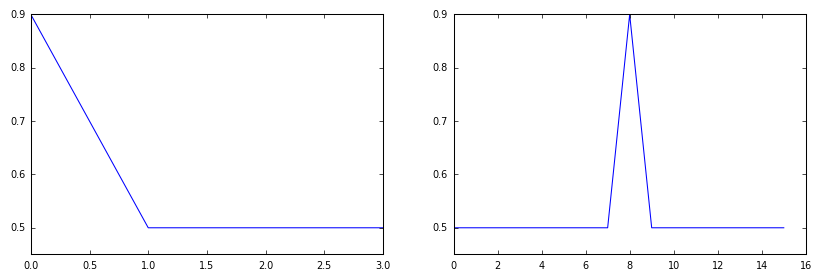

2807 3010.16


In [ ]:
env = SpikeEnv()
env.plot()

r = 0
pr = 0
for t in range(10000):
    env.randomize()
    action = np.random.permutation(env.L)[: env.K]
    r += env.regret(action)
    pr += env.pregret(action)

print(r, pr)

In [ ]:
def evaluate_one(Bandit, env, T, period_size, random_seed):
  bandit = Bandit(env.L, T)
  np.random.seed(random_seed)

  regret = np.zeros(T // period_size)
  for t in range(T):
    # generate state
    env.randomize()

    # take action
    action = bandit.get_action(t, env.K)

    # update model and regret
    bandit.update(t, action, env.reward(action))
    regret[t // period_size] += env.regret(action)

  return (regret, bandit)

def evaluate(Bandit, env, num_exps = 5, T = 1000, period_size = 1, display = True):
  if display:
    print("Simulation with %s positions and %s items" % (env.K, env.L))

  seeds = np.random.randint(2 ** 15 - 1, size = num_exps)
  output = [evaluate_one(Bandit, env, T, period_size, seeds[ex]) for ex in range(num_exps)]
  regret = np.vstack([item[0] for item in output]).T
  bandit = output[-1][1]

  if display:
    regretT = np.sum(regret, axis = 0)
    print("Regret: %.2f \\pm %.2f, " % (np.mean(regretT), np.std(regretT) / np.sqrt(num_exps)))

  return (regret, bandit)

In [ ]:
class CascadeUCB1:
  def __init__(self, K, T):
    self.K = K

    self.pulls = 1e-6 * np.ones(K) # number of pulls
    self.reward = 1e-6 * np.random.rand(K) # cumulative reward
    self.tiebreak = 1e-6 * np.random.rand(K) # tie breaking

    self.ucb = np.zeros(K)

  def update(self, t, action, r):
    if r.sum() > 0:
      last_click = np.flatnonzero(r)[-1]
      action = action[: last_click + 1]
      r = r[: last_click + 1]

    self.pulls[action] += 1
    self.reward[action] += r

    # UCBs
    t += 1 # time starts at one
    ct = np.maximum(np.sqrt(2 * np.log(t)), 2)
    self.ucb = self.reward / self.pulls + ct * np.sqrt(1 / self.pulls)

  def get_action(self, t, num_pulls):
    action = np.argsort(self.ucb + self.tiebreak)[: : -1][: num_pulls]
    return action
      
class CascadeKLUCB:
  def __init__(self, K, T):
    self.K = K

    self.pulls = 1e-6 * np.ones(K) # number of pulls
    self.reward = 1e-6 * np.random.rand(K) # cumulative reward
    self.tiebreak = 1e-6 * np.random.rand(K) # tie breaking

    self.ucb = (1 - 1e-6) * np.ones(K)

  def UCB(self, p, N, t):
    C = (np.log(t) + 3 * np.log(np.log(t) + 1)) / N
    tol = 1e-5

    kl = p * np.log(p / self.ucb) + (1 - p) * np.log((1 - p) / (1 - self.ucb))
    for k in np.flatnonzero(np.abs(kl - C) > tol):
      ql = min(max(p[k], 1e-6), 1 - 1e-6)
      qu = 1 - 1e-6
      while qu - ql > tol:
        q = (ql + qu) / 2
        f = p[k] * np.log(p[k] / q) + (1 - p[k]) * np.log((1 - p[k]) / (1 - q))
        if f < C[k]:
          ql = q
        else:
          qu = q
      self.ucb[k] = qu

  def update(self, t, action, r):
    if r.sum() > 0:
      last_click = np.flatnonzero(r)[-1]
      action = action[: last_click + 1]
      r = r[: last_click + 1]

    self.pulls[action] += 1
    self.reward[action] += r

    # UCBs
    t += 1 # time starts at one
    self.UCB(self.reward / self.pulls, self.pulls, t)

  def get_action(self, t, num_pulls):
    action = np.argsort(self.ucb + self.tiebreak)[: : -1][: num_pulls]
    return action

class TopRank:
  def __init__(self, K, T):
    self.K = K
    self.T = T

    self.pulls = np.ones((K, K)) # number of pulls
    self.reward = np.zeros((K, K)) # cumulative reward

    self.G = np.ones((K, K), dtype = bool)        
    self.P = np.zeros(K)
    self.P2 = np.ones((K, K))

  def rerank(self):
    Gt = (self.reward / self.pulls - 2 * np.sqrt(np.log(self.T) / self.pulls)) > 0
    if not np.array_equal(Gt, self.G):
      self.G = np.copy(Gt)

      Pid = 0
      self.P = - np.ones(self.K)
      while (self.P == -1).sum() > 0:
        items = np.flatnonzero(Gt.sum(axis = 0) == 0)
        self.P[items] = Pid
        Gt[items, :] = 0
        Gt[:, items] = 1
        Pid += 1

      self.P2 = \
        (np.tile(self.P[np.newaxis], (self.K, 1)) == np.tile(self.P[np.newaxis].T, (1, self.K))).astype(float)

  def update(self, t, action, r):
    clicks = np.zeros(self.K)
    clicks[action] = r

    M = np.outer(clicks, 1 - clicks) * self.P2
    self.pulls += M + M.T
    self.reward += M - M.T

    self.rerank()

  def get_action(self, t, num_pulls):
    action = np.argsort(self.P + 1e-6 * np.random.rand(self.K))[: num_pulls]
    return action

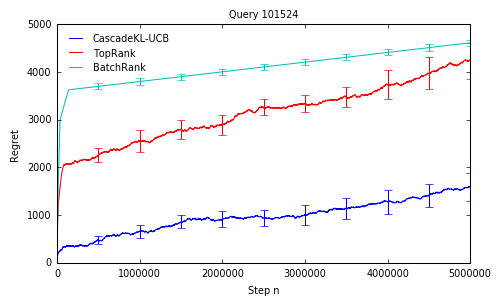

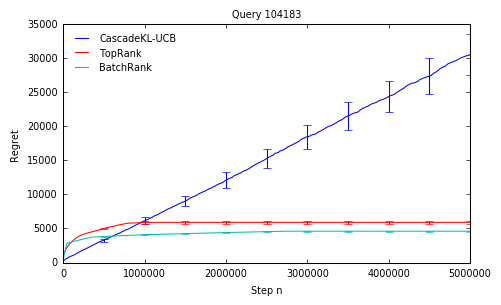

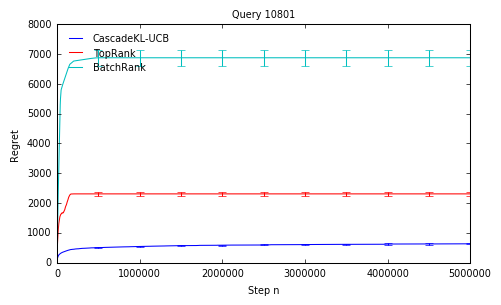

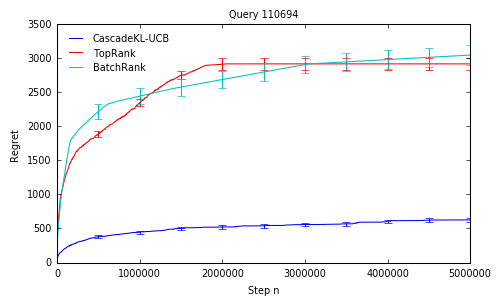

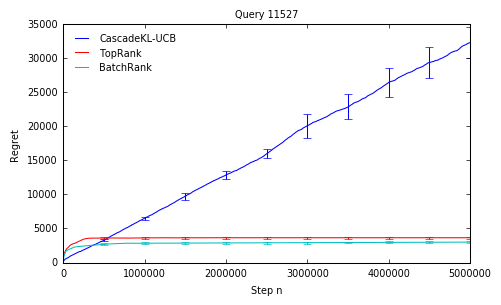

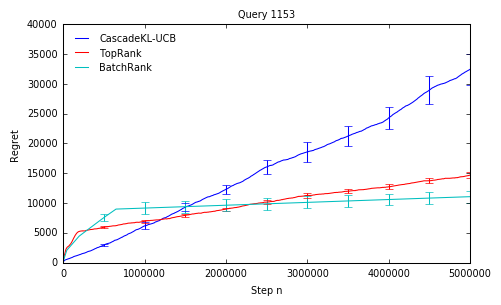

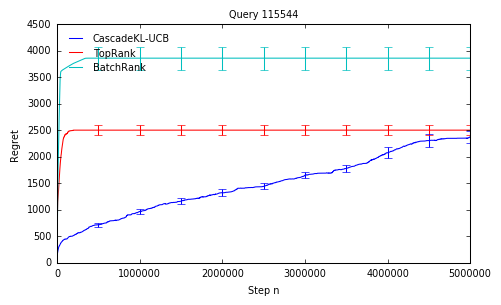

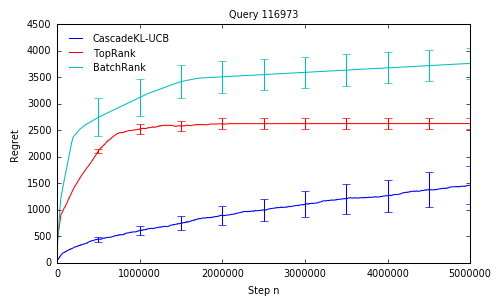

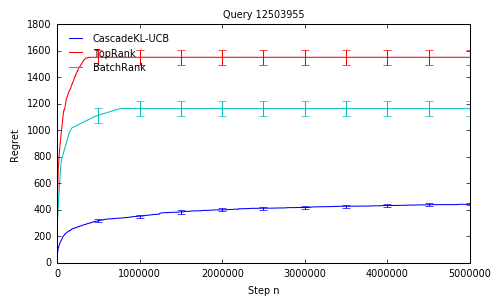

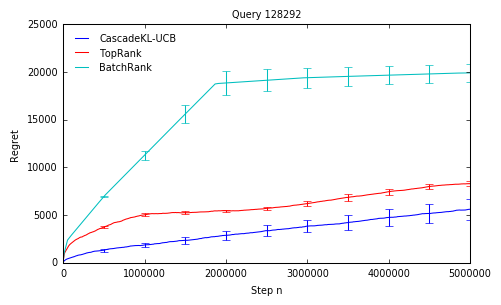

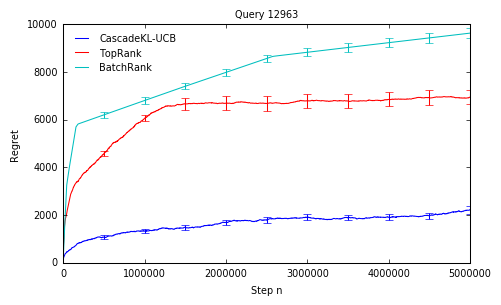

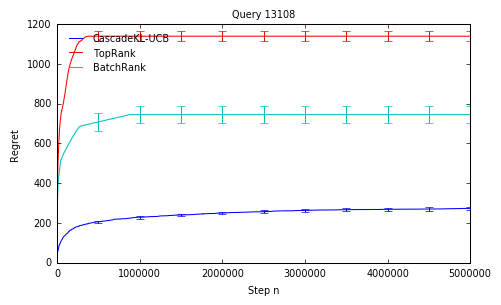

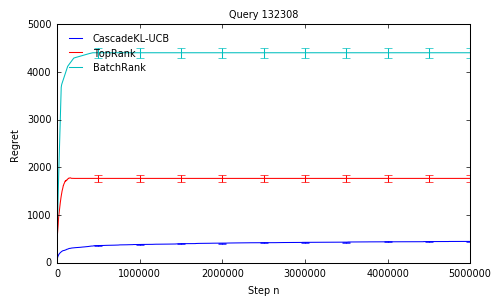

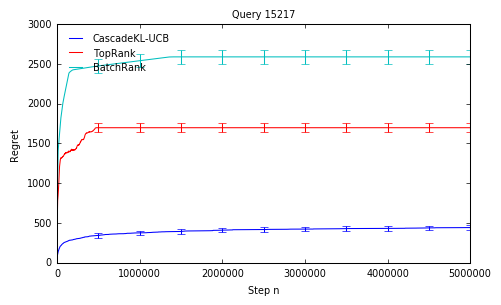

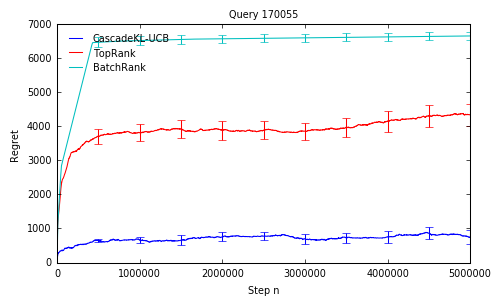

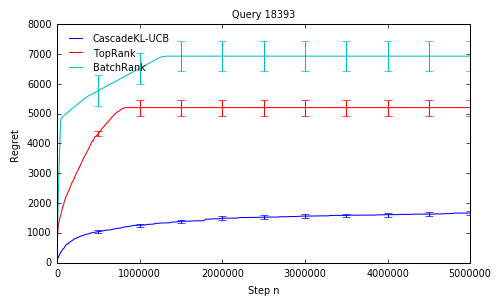

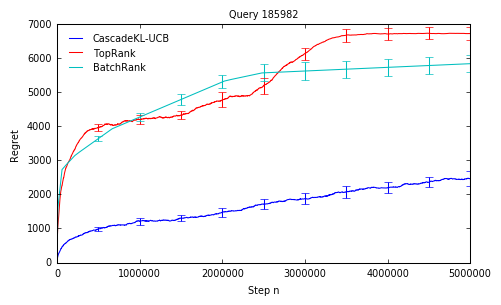

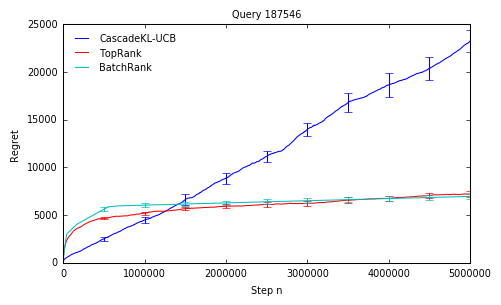

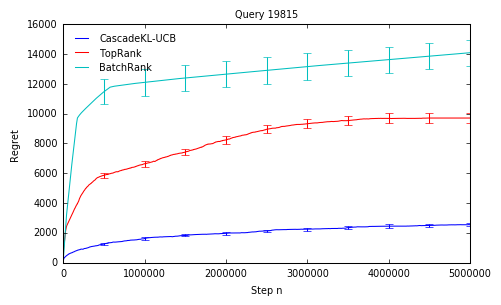

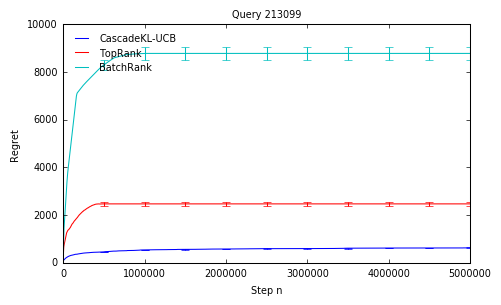

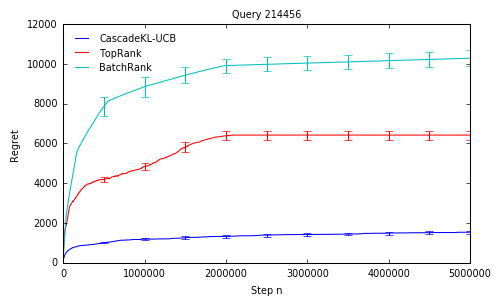

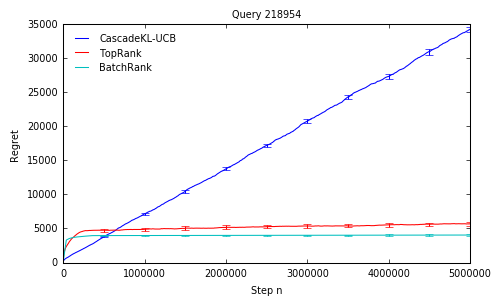

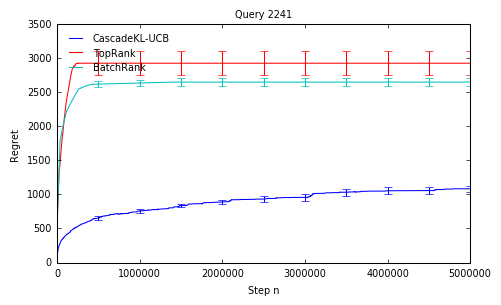

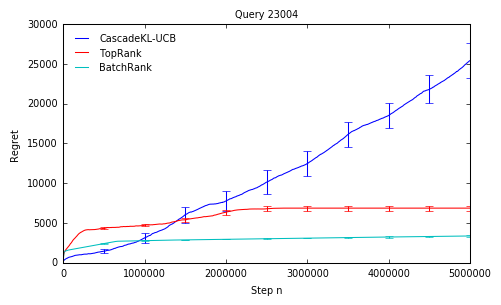

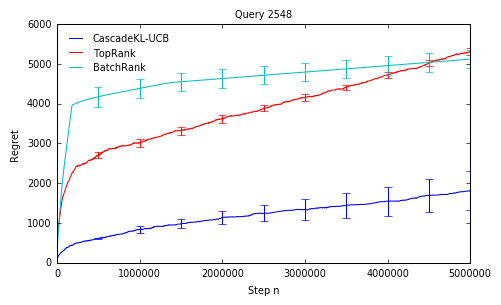

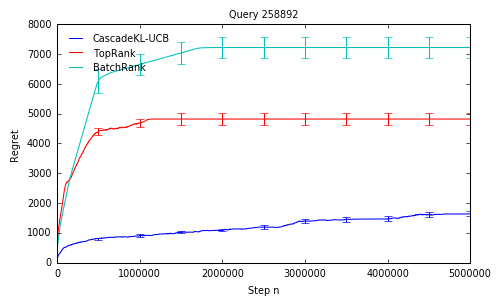

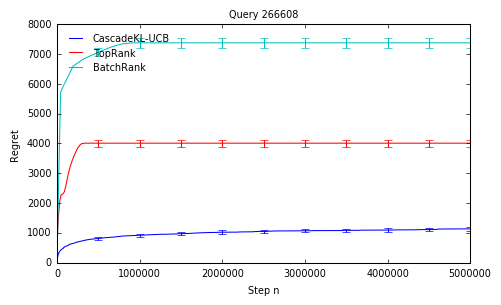

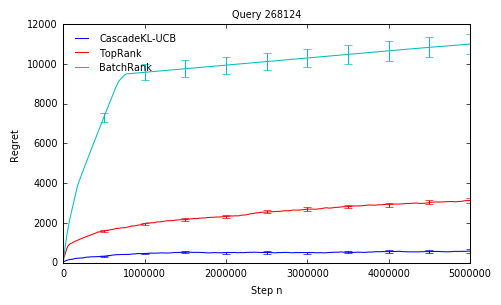

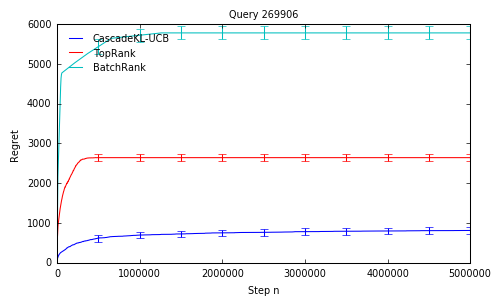

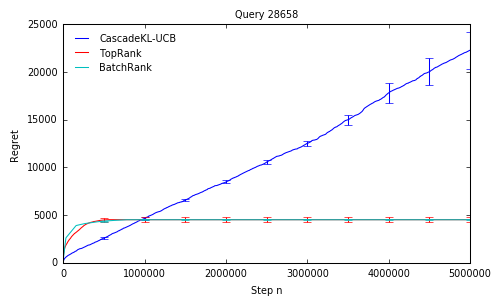

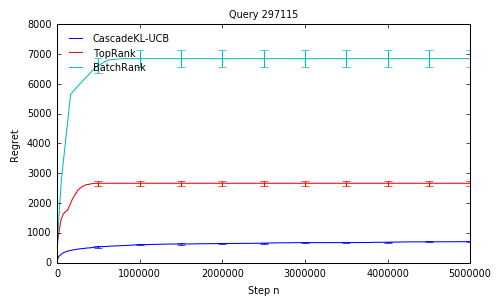

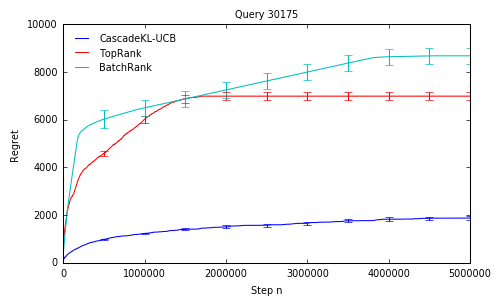

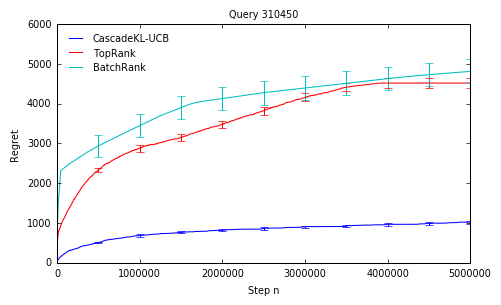

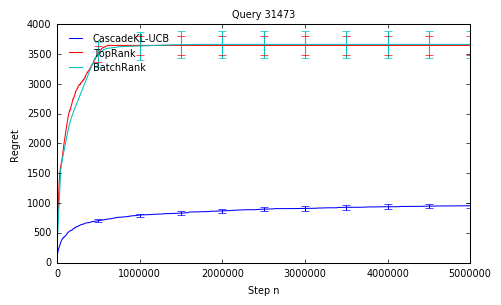

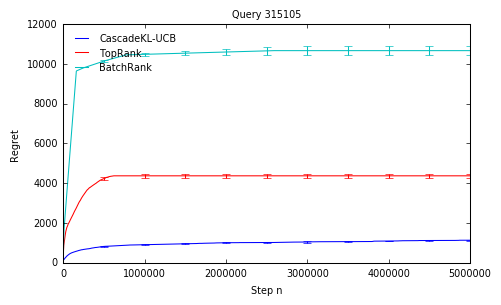

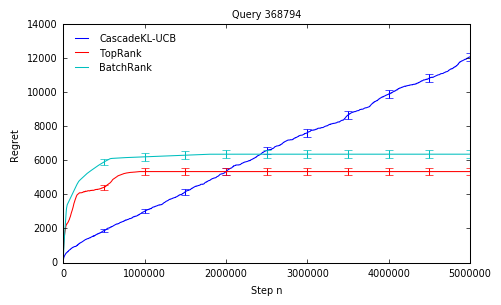

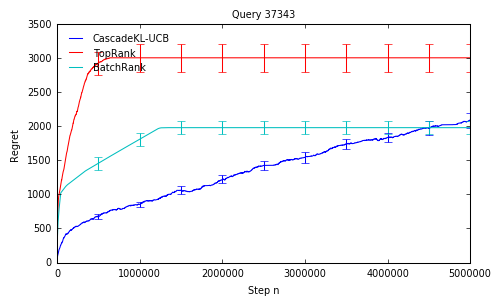

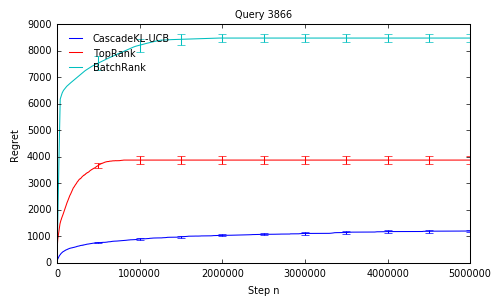

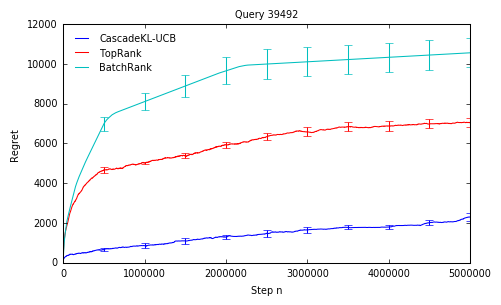

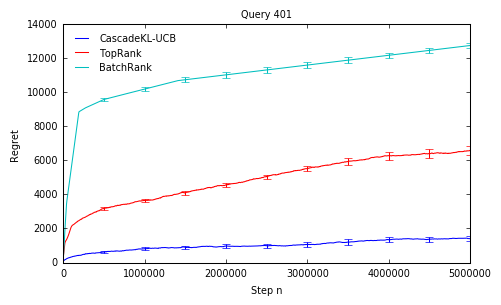

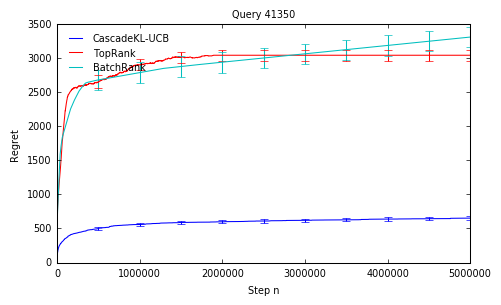

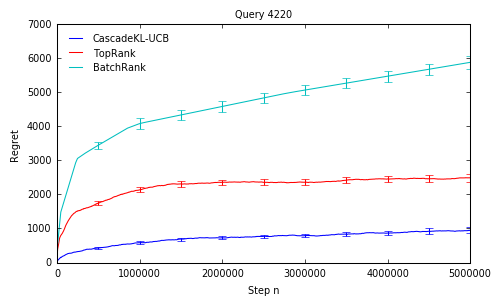

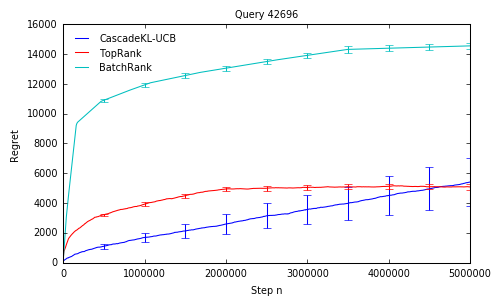

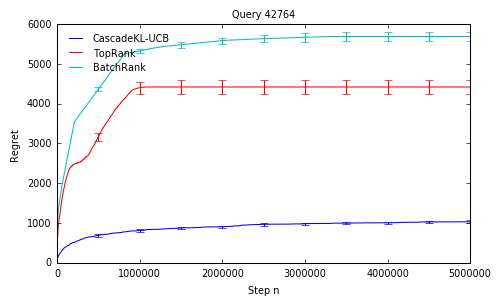

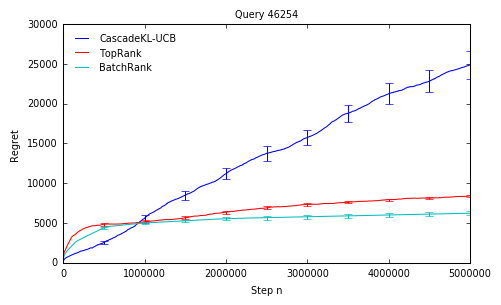

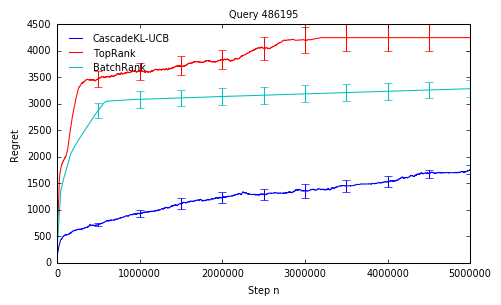

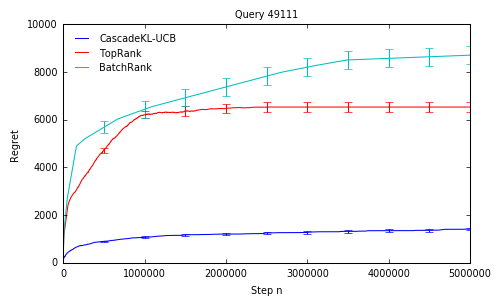

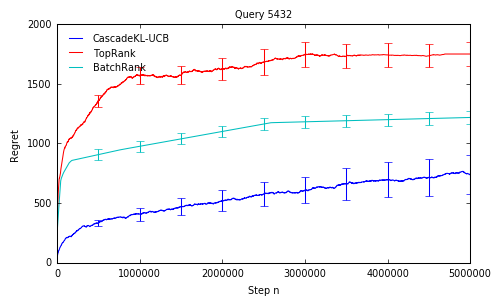

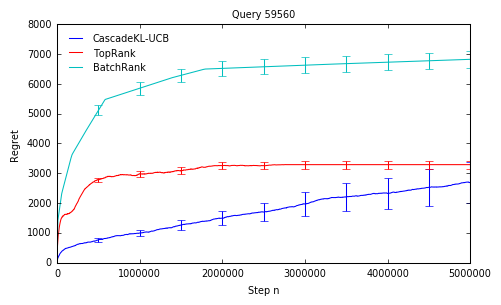

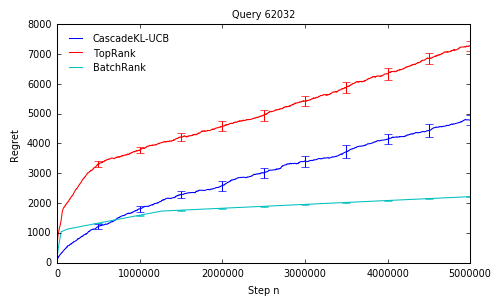

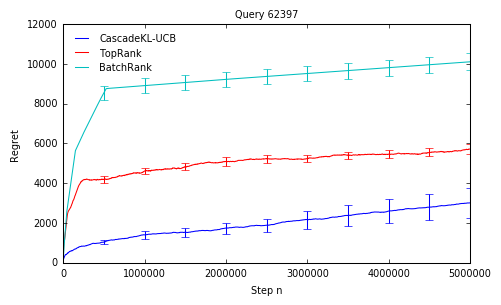

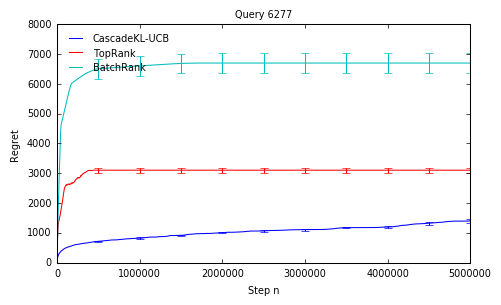

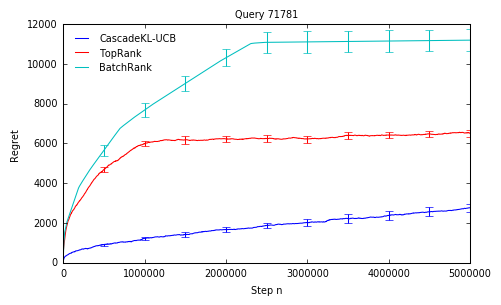

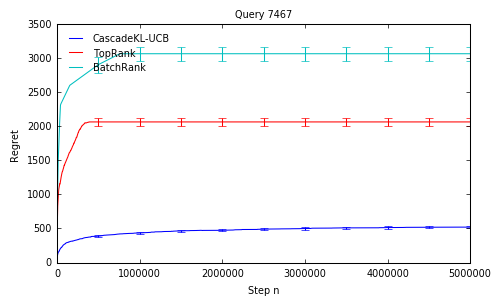

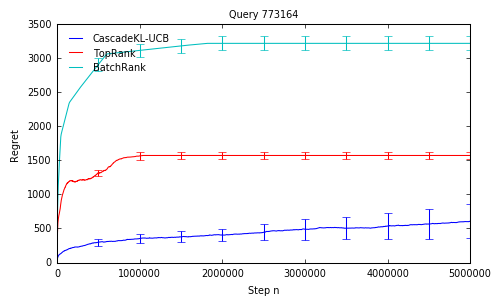

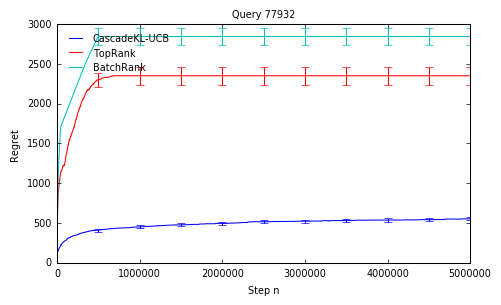

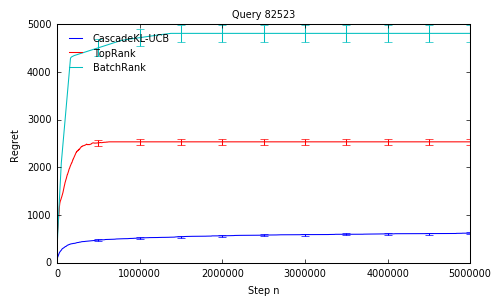

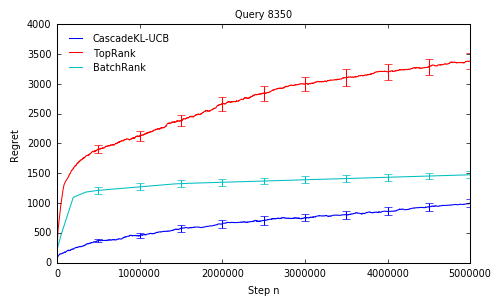

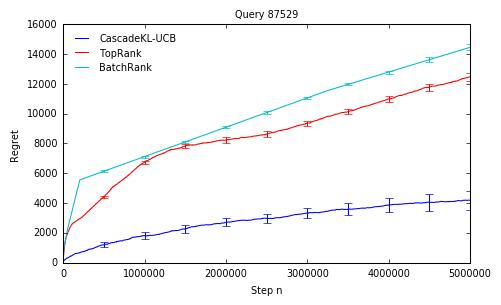

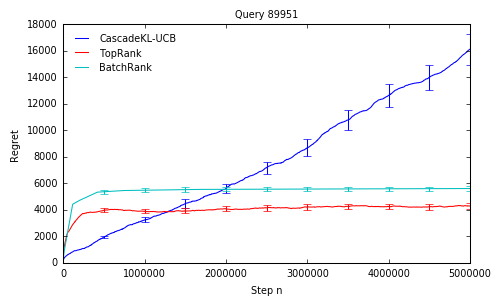

In [ ]:
# evaluation on click models
root_dir = "/cns/vq-d/home/bkveton/L2R/TopRank"
queries = [\
  "101524", "104183", "10801", "110694", "11527", "1153", "115544", "116973", "12503955", "128292", \
  "12963", "13108", "132308", "15217", "170055", "18393", "185982", "187546", "19815", "213099", \
  "214456", "218954", "2241", "23004", "2548", "258892", "266608", "268124", "269906", "28658", \
  "297115", "30175", "310450", "31473", "315105", "368794", "37343", "3866", "39492", "401", \
  "41350", "4220", "42696", "42764", "46254", "486195", "49111", "5432", "59560", "62032", \
  "62397", "6277", "71781", "7467", "773164", "77932", "82523", "8350", "87529", "89951"]
model = "PBM"

T = 5000000
num_runs = 10
period_size = 1000
num_periods = T // period_size

step = np.arange(period_size, T + 1, period_size)
sube = (step.size // 10) * np.arange(1, 11) - 1

table = bigtable.Open("/bigtable/test/bkveton.toprank").Run()
for ex in range(len(queries)):
  query = queries[ex]
  env = globals()[model + "Env"]("%s/Click Models/%s_%s.txt" % (root_dir, query, model))

#   for run in range(num_runs):
#     (regret, bandit) = evaluate(CascadeKLUCB, env, 1, T, period_size)
#     table.Set( \
#       "%s_%s_CascadeKL-UCB_%d" % (query, model, run), \
#       {"regret:": ",".join("%.3f" % s for s in regret)}, replace = True).Run()

  regret = []
  scanner = table.Scanner(prefix = "%s_%s_CascadeKL-UCB" % (query, model))
  vals = scanner.FetchColumn("regret:")
  for row in scanner:
    for val in vals:
      regret.append(np.fromstring(val, sep = ",")[:, np.newaxis])
  regret = np.hstack(regret)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "b", label = "CascadeKL-UCB")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "b")

#   for run in range(num_runs):
#     (regret, bandit) = evaluate(TopRank, env, 1, T, period_size)
#     print("Attraction |", " ".join("%.3f" % s for s in env.vbar))
#     print("Partition  |", " ".join("%5d" % s for s in bandit.P))
#     table.Set( \
#       "%s_%s_TopRank_%d" % (query, model, run), \
#       {"regret:": ",".join("%.3f" % s for s in regret)}, replace = True).Run()

  regret = []
  scanner = table.Scanner(prefix = "%s_%s_TopRank" % (query, model))
  vals = scanner.FetchColumn("regret:")
  for row in scanner:
    for val in vals:
      regret.append(np.fromstring(val, sep = ",")[:, np.newaxis])
  regret = np.hstack(regret)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "r", label = "TopRank")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "r")

  with gfile.Open("%s/Data/%s_%s_MergeRank.npy" % (root_dir, query, model)) as f:
    X = np.load(f)
  cumreg = np.cumsum(X[: num_periods, :], axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "c", label = "BatchRank")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "c")

  plt.title("Query %s" % query)
  plt.xlabel("Step n")
  plt.ylabel("Regret")
  plt.legend(loc = "upper left", frameon = False)

  plt.tight_layout()
  with gfile.Open("%s/Figures/%s_%s.pdf" % (root_dir, query, model), "w") as f:
    plt.savefig(f, format = "pdf", dpi = 1200, bbox_inches = 0)
  plt.show()

Simulation with 4 positions and 64 items
Regret: 813.90 \pm 80.68, 
Elapsed time: 12.3388860226
Simulation with 4 positions and 64 items
Regret: 2572.90 \pm 173.96, 
Elapsed time: 27.9518239498
Simulation with 4 positions and 64 items
Regret: 319.70 \pm 38.49, 
Elapsed time: 376.353008032


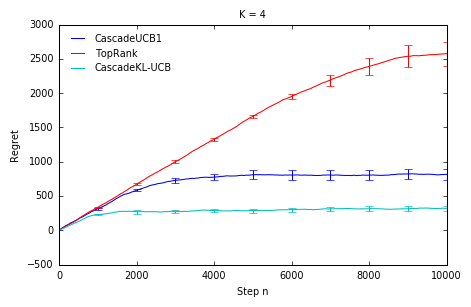

In [ ]:
# evaluation on synthetic problems
T = 10000
step = np.arange(1, T + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

for K in [4]:
    env = SpikeEnv(K, 16 * K)
    
    start = time.time()
    (regret, bandit) = evaluate(CascadeUCB1, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "b", label = "CascadeUCB1")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "b")
    print("Elapsed time:", time.time() - start)
    
    start = time.time()
    (regret, bandit) = evaluate(TopRank, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "r", label = "TopRank")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "r")
    print("Elapsed time:", time.time() - start)
    
    start = time.time()
    (regret, bandit) = evaluate(CascadeKLUCB, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "c", label = "CascadeKL-UCB")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "c")
    print("Elapsed time:", time.time() - start)
    
    plt.title("K = %d" % K)
    plt.xlabel("Step n")
    plt.ylabel("Regret")
    plt.legend(loc = "upper left", frameon = False)
    plt.show()